<a href="https://colab.research.google.com/github/ChhaviPan23/Differential-Privacy-and-Boosting/blob/main/Differential_Privacy_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn import datasets

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing(as_frame = True)

In [ ]:
universe=data.data

In [ ]:
universe = universe[:2000]

In [ ]:
import numpy as np
import random
from scipy.optimize import linprog
from collections import defaultdict

In [ ]:
def dec_1(func):
  def inner(*args,**kwargs):
    x= func(*args,**kwargs)
    return x
  return inner

@dec_1
def query_counting_l(x,a):
  if(x>a):
    return 1
  return 0

@dec_1
def query_counting_s(x,a):
  if(x<a):
    return 1
  return 0

@dec_1
def query_counting_e(x,a):
  if(x==a):
    return 1
  return 0

In [ ]:
def very_simple_sanitizer(data,query_set,arr,sensitivity,epsilon):
  scale = sensitivity / epsilon
  sanitized_dataset = {}
  m = 0
  for x in query_set:
    noise = np.random.laplace(0, scale)
    result = np.sum([x(a,arr[m]) for a in data])+noise
    sanitized_dataset[(x,arr[m])] = result
    m = m+1
  return sanitized_dataset

In [ ]:
def compute_fractional_count(data, c,l,array):
  fractional_count = 0
  for item in data:
    fractional_count +=c(item,array[l])

  return fractional_count/len(data)

In [ ]:
def method(universe,query_set,sensitivity,epsilon,arr,data_size,d,f,max_d,alpha,kappa):
  data = np.random.choice(universe,data_size,replace = False)
  if(len(query_set)//(f**d)<data_size or d==0):
    query_sel = query_set
    val = arr
    sanitized_data = very_simple_sanitizer(data,query_sel,arr,sensitivity,epsilon)
    dict_n = sanitized_data
  else:
    sanitized_data = [x[1] for x in method(universe,query_set,sensitivity,epsilon,arr,data_size,d-1,f,max_d,alpha,k)]
    idx =  np.random.choice(np.arange(len(query_set)),size = len(query_set)//(f**(max_d - d+1)),replace = False)
    query_sel = [query_set[i] for i in idx]
    val = [arr[i] for i in idx]
    dict_n = {}
    l = 0
    for c in query_sel:
      dict_n[(c,val[l])] = compute_fractional_count(sanitized_data, c,l,arr)
      l = l+1

  ai = [1 for _ in range(len(universe))]
  A_ub = []
  b_ub = []
  l = 0
  for c in query_sel:
    A_ub.append([(c(i,arr[l])-(dict_n[(c,arr[l])] + alpha)) for i in universe])
    A_ub.append([(-c(i,arr[l])+(dict_n[(c,arr[l])] - alpha)) for i in universe])
    b_ub.append(0)
    b_ub.append(0)
    l = l+1

  res = linprog(ai, A_ub=A_ub, b_ub=b_ub,method = "interior-point")
  y = [(universe[i],res.x[i]) for i in range(len(universe))]
  total_weight = sum(list(x[1] for x in y))
  y = [(x[0],x[1]/total_weight) for x in y]
  y = [(x[0],x[1]*len(universe)/alpha) for x in y]
  # m = np.ceil(np.log(len(query_set)) * kappa / alpha**2)
  # if(len(y)>m):
  #    y = random.sample(y, int(m))

  return y

In [ ]:
def compute_distance(D, Y, c,x):
    return abs(sum([c(d,x) for d in D]) - sum([c(y,x) for y in Y]))

In [ ]:
def compute_count(D,c,x):
  return sum([c(d,x) for d in D])

In [ ]:
def base_synopsis(universe,recursive_sanitizer,query_set,arr,alpha,f,kappa,epsilon):
  m = np.ceil(np.log(len(universe))*np.log(len(query_set)) * kappa / alpha**2)
  s_small = len(query_set)/f
  s_bad = len(query_set)*(kappa+m)//s_small
  alpha_prime = 2*kappa**3*np.sqrt(s_bad)/(epsilon*len(universe))
  l = 0
  u_c = []
  v_c = []
  for c in query_set:
    d = compute_distance(universe,recursive_sanitizer,c,arr[l])
    l = l+1
    noise = (np.random.binomial(4 * s_bad * kappa**4 / epsilon**2, 1))/(len(universe)*100*alpha_prime)
    u_c.append(d+noise)
    if(u_c[l-1]>alpha+2*alpha_prime):
      v_c.append((c,1))
    else:
      v_c.append((c,0))

  syn_data = {}
  l = 0
  for i in range(len(v_c)):
    if(v_c[i][1]==1):
      noise =(np.random.binomial(4 * s_bad * kappa**4 / epsilon**2, 1))/(100000*alpha_prime)
      syn_data[(v_c[i][0],arr[l])] = compute_count(universe,v_c[i][0],arr[l])+noise
    else:
      syn_data[(v_c[i][0],arr[l])] = compute_count(recursive_sanitizer,v_c[i][0],arr[l])
    l=l+1

  return syn_data

In [ ]:
def generate_base_synopsis(universe,query_set,arr,alpha,kappa,f,epsilon,sensitivity,max_d,data_size,query_set_initial,initial_queries):
  y = method(universe = universe,query_set = query_set,sensitivity = sensitivity,epsilon = epsilon,arr = arr,data_size = data_size,d = max_d-1,f = f,max_d = max_d,alpha = alpha,kappa = kappa)
  y = [x[1] for x in y]
  y = base_synopsis(universe = universe,recursive_sanitizer = y,query_set = query_set_initial,arr = initial_queries,alpha=alpha,f = f,kappa  =kappa,epsilon = epsilon)
  return y

In [ ]:
def sample_queries(distribution,k,query_set,arr):
  # Sample k queries independently and at random
  idx =  np.random.choice(np.arange(len(query_set)),p = distribution, size=k)
  sample_query = [query_set[i] for i in idx]
  val = [arr[i] for i in idx]
  return sample_query,val

def compute_base_synopsis(universe,query,val,alpha,kappa,f,epsilon,sensitivity,max_d,data_size,query_set_initial,arr):
  # Run the base synopsis generator to compute At
  return generate_base_synopsis(universe,query,val,alpha,kappa,f,epsilon,sensitivity,max_d,data_size,query_set_initial,arr);

def reweight_queries(A,query_set,data,arr,lam,mu,eta,w_queries):
  m = 0
  weights = []
  for q in query_set:
    d = compute_count(data,q,arr[m])-A[(q,arr[m])]
    d = abs(d)
    if lam < d and d< lam + mu:
      w_queries[(q,arr[m])].append(1 - 2 * (d - lam) / mu)
    elif d >= lam + mu:
      w_queries[(q,arr[m])].append(-1)
    else:
      w_queries[(q,arr[m])].append(1)
    weights.append(np.exp(-0.5*np.log((1+2*eta)/(1-2*eta))* np.sum([s for s in w_queries[(q,arr[m])]])))
    m = m+1

  return weights / np.sum(weights)

def generate_synopsis(universe,query_set,arr,k,T,lam,mu,eta,alpha,kappa,f,epsilon,sensitivity,max_d,data_size,query_demand):
  D = np.ones(len(query_set)) / len(query_set)  # Initialize uniform distribution
  dist = []
  dist.append(D)
  A_list = []
  w_queries = defaultdict(list)


  for t in range(T):
    sample_q,val = sample_queries(D,k,query_set,arr)
    A = compute_base_synopsis(universe,sample_q,val,alpha,kappa,f,epsilon,sensitivity,max_d,data_size,query_set,arr)
    D = reweight_queries(A,query_set,universe,arr,lam,mu,eta,w_queries)
    dist.append(D)
    A_list.append(A)

     # Output the data structure A as the median of A1, ..., AT for each query

  A_ = {}
  j = 0
  for q in query_set:
    A_[(q,arr[j])] = np.median([A_t[(q,arr[j])] for A_t in A_list])
    j=j+1

  return A_

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def simulate(number_of_rounds,data,query_set_size,k,T,lam,mu,eta,alpha,kappa,f,epsilon,sensitivity,max_d,data_size):
  cols = list(data.columns)
  for obj in cols:
    universe = list(data[obj])
    max_arr = max(list(universe))
    query = [query_counting_l for _ in range(query_set_size)]
    arr = [np.random.rand()*max_arr for _ in range(query_set_size)]
    idx =  np.random.choice(np.arange(len(query)),size=1)
    sample_query = [query[i] for i in idx]
    val = [arr[i] for i in idx]
    final_synopsis = []
    for_query = []

    for i in range(number_of_rounds):
      x = generate_synopsis(universe,query,arr,k,T,lam,mu,eta,alpha,kappa,f,epsilon,sensitivity,max_d,data_size,(sample_query[0],val[0]))
      for_query.append(x[(sample_query[0],val[0])])
    print("Results for the following query \n number of times "+str(obj)+" attribute has value greater than "+str(val[0]))
    ans = compute_count(universe,sample_query[0],val[0])
    plt.scatter(np.arange(number_of_rounds),for_query)
    plt.axhline(y = ans)
    plt.show()

In [ ]:
def main():
  simulate(number_of_rounds=20,data =universe,query_set_size =400,k=300,T=30,lam=266,mu=500,eta=(1/3),alpha= 1,kappa=3,f=4,epsilon=0.1,sensitivity=1,max_d=4,data_size=200)

<ipython-input-12-4f68b32d8225>:30: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(ai, A_ub=A_ub, b_ub=b_ub,method = "interior-point")


Results for the following query 
 number of times MedInc attribute has value greater than 3.5424448005263507


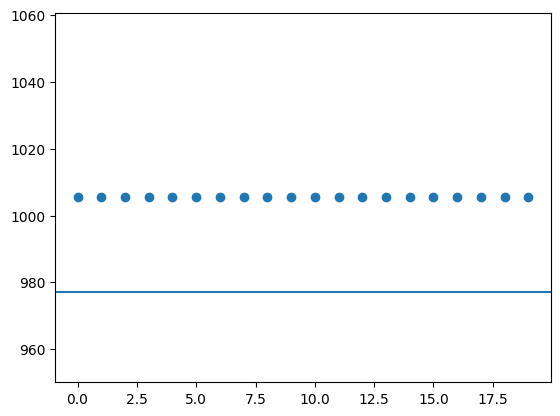

KeyboardInterrupt: 

In [ ]:
if __name__ =="__main__":
  main()